In [1]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 13.3 MB/s eta 0:00:00m eta 0:00:010:01:01


Notebook for analysing the data corpus

In [3]:
corp_path = './data'
images_path = './images'

import networkx as nx
import os
import re
import pandas as pd
import json
from matplotlib import pyplot as plt

# Read in excel, first sheet
discussion_path = corp_path + '/dataset.xlsm'
discussion_data = pd.read_excel(discussion_path).copy()

# Create interest vector for columns
interest_vector = [
    "Pseudonym",
    "Message",
    "R2DiscussionType",
    "R2Uptake",
    "R2 Pivot"
]

# Use interest vector to filter out columns
discussion_data = discussion_data[interest_vector]
# Change R2 Pivot to R2Pivot
discussion_data = discussion_data.rename(columns={"R2 Pivot": "R2Pivot"})
print(discussion_data.columns)

Index(['Pseudonym', 'Message', 'R2DiscussionType', 'R2Uptake', 'R2Pivot'], dtype='object')


# Data preprocessing
- Merge all 'imaginative entry' (different cases) values in R2DiscussionType to be same -> 'Imaginative'
- Change R2DiscussionType values with multiple types to a single one -> Split and take first value

In [4]:
# Process 'Imaginative Entry' values in R2DiscussionType
discussion_data['R2DiscussionType'] = discussion_data['R2DiscussionType'].apply(lambda x: x.replace('Imaginative Entry','Imaginative'))
discussion_data['R2DiscussionType'] = discussion_data['R2DiscussionType'].apply(lambda x: x.replace('Imaginative entry','Imaginative'))

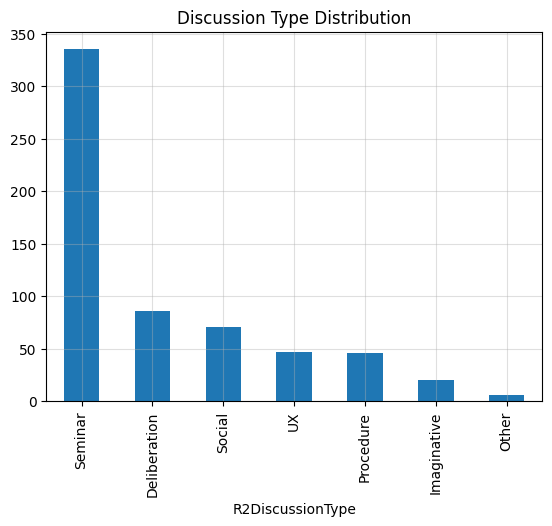

In [5]:
discussion_types = discussion_data[discussion_data['R2DiscussionType'].notna()]

# Count the number of each type of discussion
discussion_type_counts = discussion_types['R2DiscussionType'].value_counts()

# Get all discussion types with ',' in them
discussion_types_with_comma = discussion_types[discussion_types['R2DiscussionType'].str.contains(",")]

# Iterate through each discussion type with a comma
# TODO Review this later
for index, row in discussion_types_with_comma.iterrows():
    # Replace the value to only first value
    discussion_types.at[index, 'R2DiscussionType'] = row['R2DiscussionType'].split(",")[0]

# Count the number of each type of discussion
discussion_type_counts = discussion_types['R2DiscussionType'].value_counts()

discussion_type_counts.plot(kind='bar', title='Discussion Type Distribution')

# Show grid
plt.grid(alpha=0.4)

# Remove the bottom title
plt.suptitle('')

# Save the plot
plt.savefig(images_path + '/discussion_type_distribution.pdf', bbox_inches='tight')

In [6]:
# Extract all entries where 'R1 Pivot' is not none, if it is none, take the 'R2 Pivot'
pivot_entries = discussion_data[discussion_data['R2Pivot'].notna()][['R2Pivot']]
"""
G = nx.MultiDiGraph(directed=True)

# Add nodes

G.add_nodes_from(discussion_types['R2DiscussionType'].unique())

for pivot in pivot_entries:
    from_node, to_node = pivot.split(' to ', maxsplit=1)
    # Capitalize first letter of each word
    from_node = from_node[0].upper() + from_node[1:].strip()
    to_node = to_node[0].upper() + to_node[1:].strip()

    if '/' in from_node:
        from_node = from_node.split('/')[0]
    if '/' in to_node:
        to_node = to_node.split('/')[0]

    to_to_node = None

    if from_node == 'Imaginative entry':
        from_node = 'Imaginative'
    
    if to_node == 'Imaginative entry':
        to_node = 'Imaginative'

    if 'to' in to_node:
        to_node, to_to_node = to_node.split(' to ', maxsplit=1)
        to_to_node = to_to_node[0].upper() + to_to_node[1:]
    
    # Add edge
    if G.has_edge(from_node, to_node):
        G[from_node][to_node][0]['weight'] += 1
    else:
        G.add_edge(from_node, to_node, weight=1)

    if to_to_node:
        if G.has_edge(to_node, to_to_node):
            G[to_node][to_to_node][0]['weight'] += 1
        else:
            G.add_edge(to_node, to_to_node, weight=1)

# Init plot
plt.figure(figsize=(8, 8))
plt.tight_layout()
plt.title('Pivot Graph')

# Draw the graph nodes
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)

# Iterate edges
for (u, v, d) in G.edges(data=True):
    # Draw every edge separately with its weight
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=0.5*d['weight'], alpha=[0.7*d['weight']/max(G[u][v][0]['weight'], 1)], edge_color=['green' if u=='Seminar' else 'blue'],connectionstyle="arc3,rad=0.1")

# Draw the labels
_=nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Save fig
plt.savefig(images_path + '/pivot_graph.pdf', bbox_inches='tight')
"""

'\nG = nx.MultiDiGraph(directed=True)\n\n# Add nodes\n\nG.add_nodes_from(discussion_types[\'R2DiscussionType\'].unique())\n\nfor pivot in pivot_entries:\n    from_node, to_node = pivot.split(\' to \', maxsplit=1)\n    # Capitalize first letter of each word\n    from_node = from_node[0].upper() + from_node[1:].strip()\n    to_node = to_node[0].upper() + to_node[1:].strip()\n\n    if \'/\' in from_node:\n        from_node = from_node.split(\'/\')[0]\n    if \'/\' in to_node:\n        to_node = to_node.split(\'/\')[0]\n\n    to_to_node = None\n\n    if from_node == \'Imaginative entry\':\n        from_node = \'Imaginative\'\n    \n    if to_node == \'Imaginative entry\':\n        to_node = \'Imaginative\'\n\n    if \'to\' in to_node:\n        to_node, to_to_node = to_node.split(\' to \', maxsplit=1)\n        to_to_node = to_to_node[0].upper() + to_to_node[1:]\n    \n    # Add edge\n    if G.has_edge(from_node, to_node):\n        G[from_node][to_node][0][\'weight\'] += 1\n    else:\n      

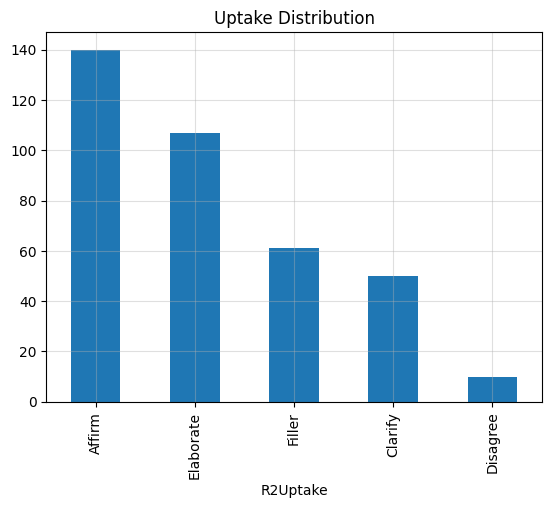

In [7]:
# Plot the uptake distribution
discussion_data['R2Uptake'].value_counts().plot(kind='bar', title='Uptake Distribution')

# Show grid
plt.grid(alpha=0.4)

# Remove the bottom title
plt.suptitle('')

# Save the plot
plt.savefig(images_path + '/uptake_distribution.pdf', bbox_inches='tight')

In [8]:
# Save df as pickle
discussion_data.to_pickle(corp_path + '/discussion_data.pkl')